In [2]:
#Here we import all the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
import amuse.plot as plot
from IPython.display import clear_output
from amuse.lab import units, constants
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import get_orbital_elements_from_binaries
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.io import write_set_to_file, read_set_from_file
from amuse.units.trigo import arctan

# Import the results of all final runs

In [3]:
data_loc = "Results/"

In [4]:
logtimes = ['-inf','4.300','4.602','4.778','4.903','4.999','5.0','5.002','5.004','5.006','5.008','5.010','5.305','5.479','5.603','5.699','5.778','6.745','7.022','7.190','7.311','7.405','7.483','7.548','7.605','7.656','7.701','7.742','7.779','7.814','7.846','7.875','7.903','7.929','7.954','7.977']

run_numbers = [8,9,10,11,12,14,15,16]
runs = ['Vanilla_Tack_run8','Vanilla_Tack_run9','Vanilla_Tack_run10','Vanilla_Tack_run11','Vanilla_Tack_run12','Vanilla_Tack_run14','Vanilla_Tack_run15','Vanilla_Tack_run16']
for run in runs:
    for i in range(len(logtimes)):
        exec(run+'_'+str(i)+'= read_set_from_file(data_loc+\"'+run+'_time='+logtimes[i]+'.hdf5\", format="hdf5")')

logtimes = [-1e9,4.300,4.602,4.778,4.903,4.999,5.0,5.002,5.004,5.006,5.008,5.010,5.305,5.479,5.603,5.699,5.778,6.745,7.022,7.190,7.311,7.405,7.483,7.548,7.605,7.656,7.701,7.742,7.779,7.814,7.846,7.875,7.903,7.929,7.954,7.977]
times = 10**np.array(logtimes)

In [5]:
sets_8GT, sets_9GT, sets_10GT, sets_11GT, sets_12GT, sets_14GT, sets_15GT, sets_16GT = [], [], [], [], [], [], [], []
for i in range(len(logtimes)):
    exec("sets_8GT.append(Vanilla_Tack_run8_"+str(i)+")")
    exec("sets_9GT.append(Vanilla_Tack_run9_"+str(i)+")")
    exec("sets_10GT.append(Vanilla_Tack_run10_"+str(i)+")")
    exec("sets_11GT.append(Vanilla_Tack_run11_"+str(i)+")")
    exec("sets_12GT.append(Vanilla_Tack_run12_"+str(i)+")")
    exec("sets_14GT.append(Vanilla_Tack_run14_"+str(i)+")")
    exec("sets_15GT.append(Vanilla_Tack_run15_"+str(i)+")")
    exec("sets_16GT.append(Vanilla_Tack_run16_"+str(i)+")")

# Define functions used for calculations

In [6]:
def separations(p1, p2):
    return (p1.position - p2.position).lengths()

def v_esc(M,r):
    return (2*constants.G*M/r).sqrt()

def v_rel(Sun, particles):
    return (Sun.velocity-particles.velocity).lengths()

def a_orbit(Sun, particles):
    return get_orbital_elements_from_binaries(Sun, particles, constants.G)[2]

def eccentricities(Sun, particles):
    return get_orbital_elements_from_binaries(Sun, particles, constants.G)[3]

def inclinations(particles):
    i = arctan(particles.z/((particles.x**2+particles.y**2).sqrt()))
    return i

## Define the Sun, which is not present in the Mercury-solved runs

In [7]:
Sun = Particles(1)
Sun.name = 'SUN'
Sun.mass = 1 | units.MSun
Sun.position = (0| units.AU, 0| units.AU, 0| units.AU)
Sun.velocity = (0|units.kms, 0| units.kms, 0|units.kms)

# Perturbation percentage (a > 100 au)

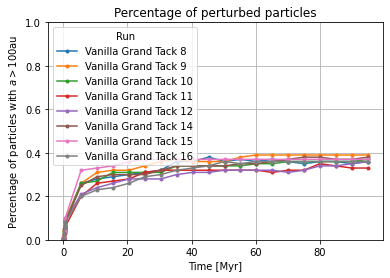

In [8]:
# Determine the percentage of particles with a > 100 AU in each timestep
def percentage_perturbed(sets):
    percentage = []
    n_particles = len(sets[0])
    for particles in sets:
        n_deleted_ps = n_particles - (len(particles))
        percentage.append((sum(((a_orbit(Sun, particles[4:]) > (100 | units.AU)) | (a_orbit(Sun, particles[4:]) < (0 | units.AU)))) + n_deleted_ps) / (n_particles-4))
    return percentage

for i in run_numbers:
    exec('perturbed_percentage_'+str(i)+'GT = percentage_perturbed(sets_'+str(i)+'GT)')
    exec('plt.plot(times/1e6, perturbed_percentage_'+str(i)+'GT, marker=\'.\', label=\'Vanilla Grand Tack '+str(i)+'\')')

plt.xlabel("Time [Myr]")
plt.ylabel(r"Percentage of particles with $a>100$au")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of perturbed particles')
plt.legend(title='Run')
plt.show()

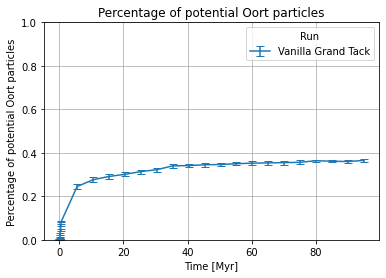

In [9]:
# Combine all runs into one mean value + std
all_perturbed_percentage = []
for i in run_numbers:
    exec('perturbed_percentage = percentage_perturbed(sets_'+str(i)+'GT)')
    all_perturbed_percentage.append(perturbed_percentage)

total_perturbed_percentage = np.mean(all_perturbed_percentage, axis=0)
plt.errorbar(times/1e6, total_perturbed_percentage, np.std(all_perturbed_percentage, axis=0)/np.sqrt(len(run_numbers)), capsize=4, label='Vanilla Grand Tack')

plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of potential Oort particles")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of potential Oort particles')
plt.legend(title='Run')
plt.show()
np.save('npy files/perturbed_GT', all_perturbed_percentage)

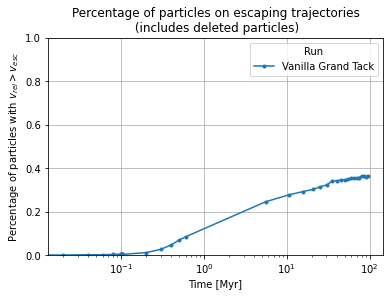

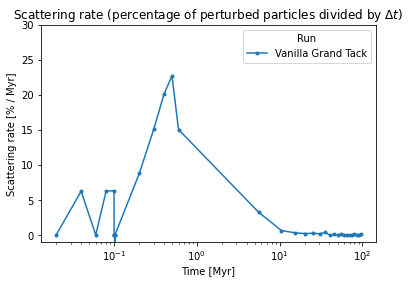

In [10]:
all_perturbed_percentages = []
for i in run_numbers:
    exec('all_perturbed_percentages.append(perturbed_percentage_'+str(i)+'GT)')
plt.plot(times/1e6, np.mean(all_perturbed_percentages, axis=0), marker='.', label='Vanilla Grand Tack')
plt.xscale('log')
plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of particles with $v_{rel}>v_{esc}$")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of particles on escaping trajectories\n (includes deleted particles)')
plt.legend(title='Run')
plt.show()


plt.plot(times[1:]/1e6, np.diff(np.mean(all_perturbed_percentages, axis=0))/np.diff(times/1e6)*100, marker='.', label='Vanilla Grand Tack')
plt.xscale('log')
plt.ylim(-1, 30)
plt.ylabel('Scattering rate [% / Myr]')
plt.xlabel('Time [Myr]')
plt.title(r'Scattering rate (percentage of perturbed particles divided by $\Delta t$)')
plt.legend(title='Run')
plt.show()
np.save('npy files/scattering_pert_rate_GT', np.diff(np.mean(all_perturbed_percentages, axis=0))/np.diff(times/1e6)*100)
np.save('npy files/scattering_pert_rate_GT_std', np.diff(np.std(all_perturbed_percentages, axis=0)/np.sqrt(len(run_numbers)))/np.diff(times/1e6)*100)

# Percentage of scattered particles

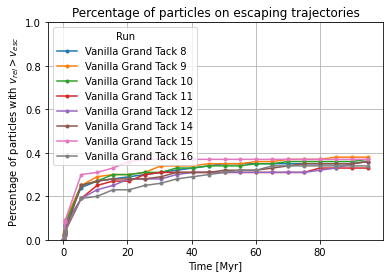

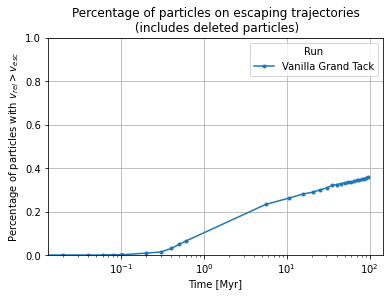

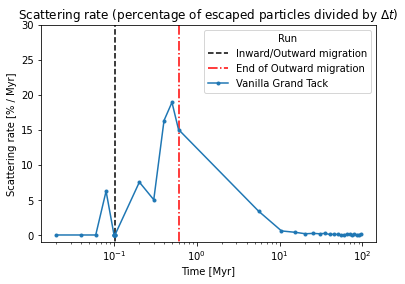

In [11]:
def percentage_vrel_vesc(sets):
    percentages = []
    n_particles = len(sets[0])
    for particles in sets:
        n_deleted_ps = n_particles - (len(particles))
        # mask gives boolean array with True where v_rel > v_esc
        mask = v_rel(Sun,particles[4:]).in_(units.km/units.s) > v_esc(Sun.mass, separations(Sun, particles[4:])).in_(units.km/units.s)
        percentages.append((sum(mask)+n_deleted_ps)/100)
    return percentages

for i in run_numbers:
    exec('escaping_percentage_'+str(i)+'GT = percentage_vrel_vesc(sets_'+str(i)+'GT)')
    exec('plt.plot(times/1e6, escaping_percentage_'+str(i)+'GT, marker=\'.\', label=\'Vanilla Grand Tack '+str(i)+'\')')


plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of particles with $v_{rel}>v_{esc}$")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of particles on escaping trajectories')
plt.legend(title='Run')
plt.show()




all_esc_percentages = []
for i in run_numbers:
    exec('all_esc_percentages.append(escaping_percentage_'+str(i)+'GT)')
plt.plot(times/1e6, np.mean(all_esc_percentages, axis=0), marker='.', label='Vanilla Grand Tack')
plt.xscale('log')
plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of particles with $v_{rel}>v_{esc}$")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of particles on escaping trajectories\n (includes deleted particles)')
plt.legend(title='Run')
plt.show()


plt.errorbar(times[1:]/1e6, np.diff(np.mean(all_esc_percentages, axis=0))/np.diff(times/1e6)*100, marker='.', label='Vanilla Grand Tack')
plt.vlines(0.1025, -10, 100, linestyle='--', label='Inward/Outward migration', color='black')
plt.vlines(0.6, -10, 100, linestyle='-.', label='End of Outward migration', color='red')
plt.xscale('log')
plt.ylim(-1, 30)
plt.ylabel('Scattering rate [% / Myr]')
plt.xlabel('Time [Myr]')
plt.title(r'Scattering rate (percentage of escaped particles divided by $\Delta t$)')
plt.legend(title='Run')
plt.show()
np.save('npy files/scattering_rate_GT', np.diff(np.mean(all_esc_percentages, axis=0))/np.diff(times/1e6)*100)
np.save('npy files/scattering_rate_GT_std', np.diff(np.std(all_esc_percentages, axis=0)/np.sqrt(len(run_numbers)))/np.diff(times/1e6)*100)

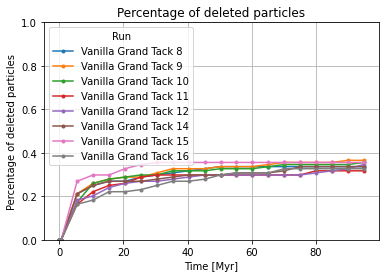

In [12]:
def percentage_deleted(sets):
    n_particles = len(sets[0])
    n_deleted = []
    for particles in sets:
        n_deleted.append(n_particles - len(particles))
    percentage = np.array(n_deleted) / n_particles
    return percentage

for i in run_numbers:
    exec('deleted_percentage_'+str(i)+'GT = percentage_deleted(sets_'+str(i)+'GT)')
    exec('plt.plot(times/1e6, deleted_percentage_'+str(i)+'GT, marker=\'.\', label=\'Vanilla Grand Tack '+str(i)+'\')')

plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of deleted particles")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of deleted particles')
plt.legend(title='Run')
plt.show()

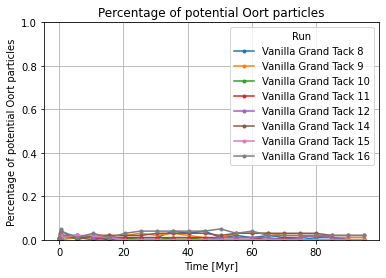

In [13]:
def percentage_pot_Oort(sets):
    # Find particles that have a>100au, v_rel < v_esc, r<250.000au and e<1
    percentages = []
    for i in range(len(logtimes)):
        n_deleted = len(sets[0])-len(sets[i])
        n_oort_objs = len(np.argwhere((a_orbit(Sun, sets[i][4:]) > (100|units.AU)) & (v_rel(Sun, sets[i][4:]).in_(units.km/units.s) < v_esc(Sun.mass, separations(Sun, sets[i][4:])).in_(units.km/units.s)) & (separations(Sun, sets[i][4:])<(250000|units.AU)) & (eccentricities(Sun, sets[i][4:]) < 1)))
        percentages.append((n_oort_objs) / len(sets[0][4:]))
    return percentages

for i in run_numbers:
    exec('pot_Oort_percentage_'+str(i)+'GT = percentage_pot_Oort(sets_'+str(i)+'GT)')
    exec('plt.plot(times/1e6, pot_Oort_percentage_'+str(i)+'GT, marker=\'.\', label=\'Vanilla Grand Tack '+str(i)+'\')')

plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of potential Oort particles")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of potential Oort particles')
plt.legend(title='Run')
plt.show()

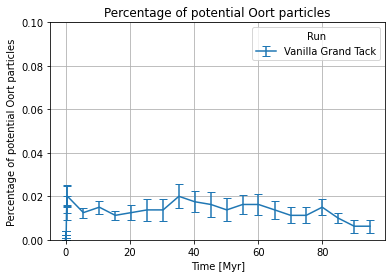

In [14]:
all_pot_Oort_percentage = []
for i in run_numbers:
    exec('pot_Oort_percentage = percentage_pot_Oort(sets_'+str(i)+'GT)')
    all_pot_Oort_percentage.append(pot_Oort_percentage)

total_pot_Oort_percentage = np.mean(all_pot_Oort_percentage, axis=0)
plt.errorbar(times/1e6, total_pot_Oort_percentage, np.std(all_pot_Oort_percentage, axis=0)/np.sqrt(len(run_numbers)), capsize=4, label='Vanilla Grand Tack')

plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of potential Oort particles")
plt.grid()
plt.ylim(0, 0.1)
plt.title('Percentage of potential Oort particles')
plt.legend(title='Run')
plt.show()
np.save('npy files/pot_Oort_GT', all_pot_Oort_percentage)

In [15]:
def find_pot_Oort_keys(sets): # Takes all particles that were *at some point during the run* classified as pot. Oort cloud object
    keys = []
    for i in range(len(times)):
        oort_objs = np.argwhere((a_orbit(Sun, sets[i]) > (100|units.AU)) & (v_rel(Sun, sets[i]).in_(units.km/units.s) < v_esc(Sun.mass, separations(Sun, sets[i])).in_(units.km/units.s)) & (separations(Sun, sets[i])<(250000|units.AU)) & (eccentricities(Sun, sets[i]) < 1))
        for index in oort_objs:
            if sets[i][index].key not in keys:
                keys.append(sets[i][index].key)
    return keys

def find_pot_Oort_keys2(sets): # Takes all particles that were classified as pot. Oort cloud object *in the last timestep*
    oort_objs = sets[-1][((a_orbit(Sun, sets[-1]) > (100|units.AU)) & (v_rel(Sun, sets[-1]).in_(units.km/units.s) < v_esc(Sun.mass, separations(Sun, sets[-1])).in_(units.km/units.s)) & (separations(Sun, sets[-1])<(250000|units.AU)) & (eccentricities(Sun, sets[-1]) < 1))]
    keys = oort_objs.key
    return keys

In [16]:
def begin_a(sets, keys):
    Oort_a = np.array([])
    for key in keys:
        Oort_a = np.append(Oort_a, a_orbit(Sun, sets[0][sets[0].key==key]).in_(units.AU).number)
    return (Oort_a | units.AU)

def begin_e(sets, keys):
    Oort_e = np.array([])
    for key in keys:
        Oort_e = np.append(Oort_e, eccentricities(Sun, sets[0][sets[0].key==key]))
    return Oort_e

def begin_i(sets, keys):
    Oort_i = np.array([])
    for key in keys:
        Oort_i = np.append(Oort_i, inclinations(sets[0][sets[0].key==key]).in_(units.deg).number)
    return (Oort_i | units.deg)

## Particles that were classified as potential Oort cloud objects *in the last time step*

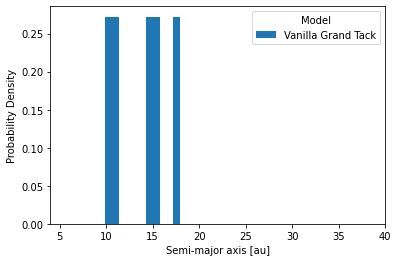

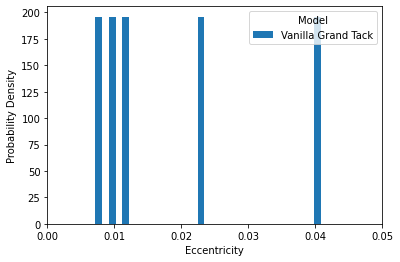

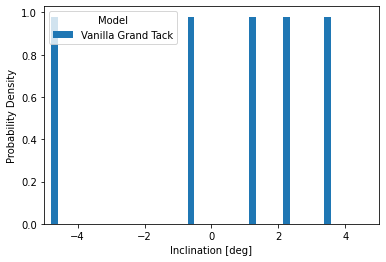

In [17]:
initial_as, initial_es, initial_is = np.array([]), np.array([]), np.array([])
for i in run_numbers:
    exec('temp_keys = find_pot_Oort_keys2(sets_'+str(i)+'GT)')
    if len(temp_keys) > 0:
        exec('initial_as = np.append(initial_as, begin_a(sets_'+str(i)+'GT, temp_keys).value_in(units.AU))')
        exec('initial_es = np.append(initial_es, begin_e(sets_'+str(i)+'GT, temp_keys))')
        exec('initial_is = np.append(initial_is, begin_i(sets_'+str(i)+'GT, temp_keys).value_in(units.deg))')
    
    
plot.hist(initial_as, bins=np.linspace(4,40,50), label='Vanilla Grand Tack', density=True)
plt.xlim(4,40)
plt.xlabel('Semi-major axis [au]')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()
np.save('npy files/initial_as_GT', initial_as)

plot.hist(initial_es, bins=np.linspace(0,0.05,50), label='Vanilla Grand Tack', density=True)
plt.xlim(0,0.05)
plt.xlabel('Eccentricity')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()

plot.hist(initial_is, bins=np.linspace(-5,5,50), label='Vanilla Grand Tack', density=True)
plt.xlim(-5,5)
plt.xlabel('Inclination [deg]')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()

## Particles that were *at some point in time* perturbed

In [19]:
def find_perturbed_keys(sets): # Takes all particles that were *at some point during the run* ejected
    keys = []
    for i in range(len(times)):
        oort_objs = np.argwhere((a_orbit(Sun, sets[i]) > (100|units.AU)) | (v_rel(Sun, sets[i]).in_(units.km/units.s) > v_esc(Sun.mass, separations(Sun, sets[i])).in_(units.km/units.s)))
        for index in oort_objs:
            if sets[i][index].key not in keys:
                keys.append(sets[i][index].key)
    return keys

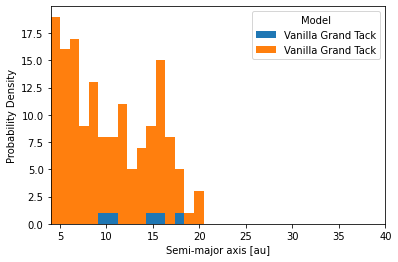

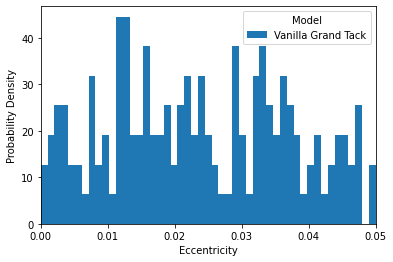

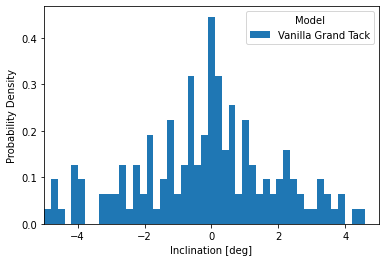

In [20]:
initial_as2, initial_es, initial_is = np.array([]), np.array([]), np.array([])
for i in run_numbers:
    exec('temp_keys = find_perturbed_keys(sets_'+str(i)+'GT)')
    if len(temp_keys) > 0:
        exec('initial_as2 = np.append(initial_as2, begin_a(sets_'+str(i)+'GT, temp_keys).value_in(units.AU))')
        exec('initial_es = np.append(initial_es, begin_e(sets_'+str(i)+'GT, temp_keys))')
        exec('initial_is = np.append(initial_is, begin_i(sets_'+str(i)+'GT, temp_keys).value_in(units.deg))')
    
    
plot.hist(initial_as, bins=np.linspace(4,40,36), label='Vanilla Grand Tack', density=False)
plot.hist(initial_as2, bins=np.linspace(4,40,36), label='Vanilla Grand Tack', density=False, zorder=-2)
plt.xlim(4,40)
plt.xlabel('Semi-major axis [au]')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()
np.save('npy files/initial_as2_GT', initial_as2)

plot.hist(initial_es, bins=np.linspace(0,0.05,50), label='Vanilla Grand Tack', density=True)
plt.xlim(0,0.05)
plt.xlabel('Eccentricity')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()

plot.hist(initial_is, bins=np.linspace(-5,5,50), label='Vanilla Grand Tack', density=True)
plt.xlim(-5,5)
plt.xlabel('Inclination [deg]')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()